# FullClass-TrainCNN_FreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=224
img_width=224
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


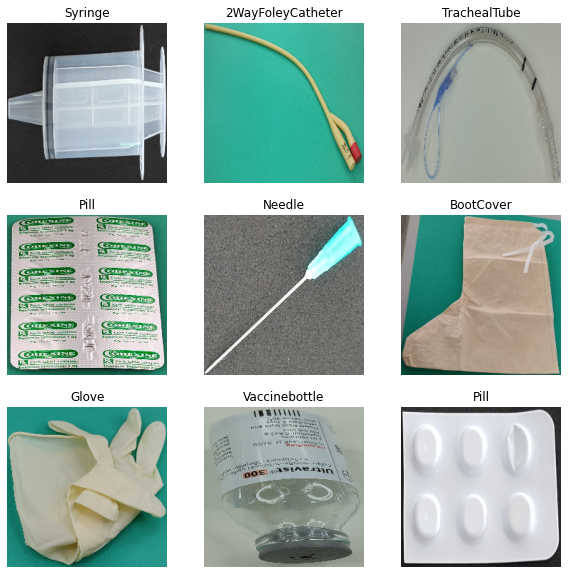

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("vertical"),
  layers.RandomRotation(0.100),
  layers.RandomZoom(height_factor=0.025,width_factor=0.025),
  #layers.RandomContrast(0.300),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  # ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input,EfficientNetB0

efficientnetB0_model = keras.applications.EfficientNetB0(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

efficientnetB0_model_nooutput = efficientnetB0_model.layers[-3].output
custom_efficientnetB0_model = Model(inputs = efficientnetB0_model.input, outputs = efficientnetB0_model_nooutput)


## Freez Extractor+

In [18]:
custom_efficientnetB0_model.trainable = False
for layer in custom_efficientnetB0_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_efficientnetB0_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [19]:
#tf.keras.utils.plot_model(custom_efficientnetB0_model, to_file="InceptionRemoveOutput.png", show_shapes=True)

In [20]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_efficientnetB0_model)
# Classifier
#DeepDense
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 1280)              4049571   
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 41)                42025     
Total params: 5,403,340
Trainable params: 1,353,769
Non-trainable params: 4,049,571
_________________________________________________________________


In [22]:
class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

In [23]:
#model.layers[-1]._name = 'Classifier'
#model.layers[-2]._name = 'InceptionV3'
#print(len(model.layers))
#tf.keras.utils.plot_model(model, to_file="Incepv3_FreezExtractorOurOutputLayer.png", show_shapes=True)

# Fitting

In [1]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/EfficientNetB0_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/'

In [25]:
EPOCHS = 2000
save_model_interval = 200
checkpoint_filepath = path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch{epoch:04d}.pb' # -val_acc{val_accuracy:.2f}
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/2000
49/49 [==============================] - 39s 242ms/step - loss: 1.0858 - accuracy: 0.7141 - val_loss: 0.3123 - val_accuracy: 0.9107
Epoch 2/2000
49/49 [==============================] - 5s 106ms/step - loss: 0.1927 - accuracy: 0.9548 - val_loss: 0.1710 - val_accuracy: 0.9573
Epoch 3/2000
49/49 [==============================] - 5s 106ms/step - loss: 0.0999 - accuracy: 0.9771 - val_loss: 0.1489 - val_accuracy: 0.9599
Epoch 4/2000
49/49 [==============================] - 5s 106ms/step - loss: 0.0629 - accuracy: 0.9884 - val_loss: 0.1393 - val_accuracy: 0.9625
Epoch 5/2000
49/49 [==============================] - 5s 106ms/step - loss: 0.0484 - accuracy: 0.9884 - val_loss: 0.1349 - val_accuracy: 0.9625
Epoch 6/2000
49/49 [==============================] - 5s 106ms/step - loss: 0.0359 - accuracy: 0.9932 - val_loss: 0.1181 - val_accuracy: 0.9664
Epoch 7/2000
49/49 [==============================] - 5s 106ms/step - loss: 0.0246 - accuracy: 0.9958 - val_loss: 0.1367 - val_accuracy

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 201/2000
49/49 [==============================] - 6s 107ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.0966 - val_accuracy: 0.9767
Epoch 202/2000
49/49 [==============================] - 5s 106ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0954 - val_accuracy: 0.9754
Epoch 203/2000
49/49 [==============================] - 5s 106ms/step - loss: 0.0027 - accuracy: 0.9990 - val_loss: 0.0964 - val_accuracy: 0.9754
Epoch 204/2000
49/49 [==============================] - 5s 106ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0965 - val_accuracy: 0.9741
Epoch 205/2000
49/49 [==============================] - 5s 106ms/step - loss: 0.0026 - accuracy: 0.9990 - val_loss: 0.0972 - val_accuracy: 0.9741
Epoch 206/2000
49/49 [==============================] - 5s 106ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0971 - val_accuracy: 0.9728
Epoch 207/2000
49/49 [==============================] - 5s 106ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0964 -

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 401/2000
49/49 [==============================] - 5s 106ms/step - loss: 6.4181e-04 - accuracy: 1.0000 - val_loss: 0.1008 - val_accuracy: 0.9741
Epoch 402/2000
49/49 [==============================] - 5s 107ms/step - loss: 8.5081e-04 - accuracy: 1.0000 - val_loss: 0.1007 - val_accuracy: 0.9741
Epoch 403/2000
49/49 [==============================] - 5s 106ms/step - loss: 6.8766e-04 - accuracy: 1.0000 - val_loss: 0.1004 - val_accuracy: 0.9754
Epoch 404/2000
49/49 [==============================] - 5s 106ms/step - loss: 9.2495e-04 - accuracy: 1.0000 - val_loss: 0.1011 - val_accuracy: 0.9741
Epoch 405/2000
49/49 [==============================] - 5s 106ms/step - loss: 9.3368e-04 - accuracy: 1.0000 - val_loss: 0.1007 - val_accuracy: 0.9754
Epoch 406/2000
49/49 [==============================] - 5s 106ms/step - loss: 0.0031 - accuracy: 0.9997 - val_loss: 0.1003 - val_accuracy: 0.9767
Epoch 407/2000
49/49 [==============================] - 5s 106ms/step - loss: 0.0014 - accuracy: 0.9997 

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 601/2000
49/49 [==============================] - 5s 107ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.1063 - val_accuracy: 0.9702
Epoch 602/2000
49/49 [==============================] - 5s 107ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.1060 - val_accuracy: 0.9715
Epoch 603/2000
49/49 [==============================] - 5s 107ms/step - loss: 5.6431e-04 - accuracy: 1.0000 - val_loss: 0.1062 - val_accuracy: 0.9715
Epoch 604/2000
49/49 [==============================] - 5s 107ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.1064 - val_accuracy: 0.9715
Epoch 605/2000
49/49 [==============================] - 5s 107ms/step - loss: 0.0014 - accuracy: 0.9994 - val_loss: 0.1063 - val_accuracy: 0.9715
Epoch 606/2000
49/49 [==============================] - 5s 107ms/step - loss: 4.9760e-04 - accuracy: 1.0000 - val_loss: 0.1047 - val_accuracy: 0.9728
Epoch 607/2000
49/49 [==============================] - 5s 107ms/step - loss: 8.3671e-04 - accuracy: 0.9997 - val_lo

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 801/2000
49/49 [==============================] - 5s 107ms/step - loss: 0.0014 - accuracy: 0.9994 - val_loss: 0.1071 - val_accuracy: 0.9754
Epoch 802/2000
49/49 [==============================] - 5s 106ms/step - loss: 9.7106e-04 - accuracy: 1.0000 - val_loss: 0.1077 - val_accuracy: 0.9754
Epoch 803/2000
49/49 [==============================] - 5s 106ms/step - loss: 0.0010 - accuracy: 0.9997 - val_loss: 0.1092 - val_accuracy: 0.9754
Epoch 804/2000
49/49 [==============================] - 5s 106ms/step - loss: 4.3557e-04 - accuracy: 1.0000 - val_loss: 0.1089 - val_accuracy: 0.9741
Epoch 805/2000
49/49 [==============================] - 5s 106ms/step - loss: 9.9857e-04 - accuracy: 0.9997 - val_loss: 0.1091 - val_accuracy: 0.9741
Epoch 806/2000
49/49 [==============================] - 5s 106ms/step - loss: 0.0017 - accuracy: 0.9994 - val_loss: 0.1093 - val_accuracy: 0.9741
Epoch 807/2000
49/49 [==============================] - 5s 106ms/step - loss: 2.9128e-04 - accuracy: 1.0000 - va

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1001/2000
49/49 [==============================] - 6s 107ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.1070 - val_accuracy: 0.9754
Epoch 1002/2000
49/49 [==============================] - 5s 106ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.1052 - val_accuracy: 0.9754
Epoch 1003/2000
49/49 [==============================] - 5s 107ms/step - loss: 9.6827e-04 - accuracy: 1.0000 - val_loss: 0.1047 - val_accuracy: 0.9754
Epoch 1004/2000
49/49 [==============================] - 5s 106ms/step - loss: 5.2477e-04 - accuracy: 0.9997 - val_loss: 0.1057 - val_accuracy: 0.9754
Epoch 1005/2000
49/49 [==============================] - 5s 106ms/step - loss: 7.8203e-04 - accuracy: 1.0000 - val_loss: 0.1054 - val_accuracy: 0.9754
Epoch 1006/2000
49/49 [==============================] - 5s 106ms/step - loss: 3.9521e-04 - accuracy: 1.0000 - val_loss: 0.1055 - val_accuracy: 0.9754
Epoch 1007/2000
49/49 [==============================] - 5s 106ms/step - loss: 6.0689e-04 - accuracy: 

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1201/2000
49/49 [==============================] - 5s 106ms/step - loss: 0.0013 - accuracy: 0.9994 - val_loss: 0.1065 - val_accuracy: 0.9754
Epoch 1202/2000
49/49 [==============================] - 5s 106ms/step - loss: 2.3795e-04 - accuracy: 1.0000 - val_loss: 0.1064 - val_accuracy: 0.9754
Epoch 1203/2000
49/49 [==============================] - 5s 106ms/step - loss: 7.9008e-04 - accuracy: 1.0000 - val_loss: 0.1062 - val_accuracy: 0.9754
Epoch 1204/2000
49/49 [==============================] - 5s 106ms/step - loss: 3.5207e-04 - accuracy: 1.0000 - val_loss: 0.1062 - val_accuracy: 0.9767
Epoch 1205/2000
49/49 [==============================] - 5s 106ms/step - loss: 2.3648e-04 - accuracy: 1.0000 - val_loss: 0.1065 - val_accuracy: 0.9767
Epoch 1206/2000
49/49 [==============================] - 5s 106ms/step - loss: 1.7073e-04 - accuracy: 1.0000 - val_loss: 0.1065 - val_accuracy: 0.9767
Epoch 1207/2000
49/49 [==============================] - 5s 106ms/step - loss: 2.0269e-04 - accura

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1401/2000
49/49 [==============================] - 6s 108ms/step - loss: 3.7391e-04 - accuracy: 1.0000 - val_loss: 0.1070 - val_accuracy: 0.9754
Epoch 1402/2000
49/49 [==============================] - 5s 107ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.1064 - val_accuracy: 0.9754
Epoch 1403/2000
49/49 [==============================] - 5s 107ms/step - loss: 1.7208e-04 - accuracy: 1.0000 - val_loss: 0.1066 - val_accuracy: 0.9754
Epoch 1404/2000
49/49 [==============================] - 5s 107ms/step - loss: 8.2141e-04 - accuracy: 1.0000 - val_loss: 0.1076 - val_accuracy: 0.9741
Epoch 1405/2000
49/49 [==============================] - 5s 107ms/step - loss: 6.1833e-04 - accuracy: 0.9997 - val_loss: 0.1070 - val_accuracy: 0.9754
Epoch 1406/2000
49/49 [==============================] - 5s 107ms/step - loss: 9.0598e-04 - accuracy: 1.0000 - val_loss: 0.1074 - val_accuracy: 0.9754
Epoch 1407/2000
49/49 [==============================] - 5s 107ms/step - loss: 3.7247e-04 - accura

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1601/2000
49/49 [==============================] - 6s 106ms/step - loss: 2.8734e-04 - accuracy: 1.0000 - val_loss: 0.1107 - val_accuracy: 0.9754
Epoch 1602/2000
49/49 [==============================] - 5s 106ms/step - loss: 1.8509e-04 - accuracy: 1.0000 - val_loss: 0.1099 - val_accuracy: 0.9754
Epoch 1603/2000
49/49 [==============================] - 5s 106ms/step - loss: 1.9123e-04 - accuracy: 1.0000 - val_loss: 0.1099 - val_accuracy: 0.9754
Epoch 1604/2000
49/49 [==============================] - 5s 106ms/step - loss: 1.3935e-04 - accuracy: 1.0000 - val_loss: 0.1097 - val_accuracy: 0.9754
Epoch 1605/2000
49/49 [==============================] - 5s 106ms/step - loss: 2.1073e-04 - accuracy: 1.0000 - val_loss: 0.1093 - val_accuracy: 0.9754
Epoch 1606/2000
49/49 [==============================] - 5s 106ms/step - loss: 1.6327e-04 - accuracy: 1.0000 - val_loss: 0.1093 - val_accuracy: 0.9754
Epoch 1607/2000
49/49 [==============================] - 5s 106ms/step - loss: 3.9804e-04 - ac

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1801/2000
49/49 [==============================] - 5s 106ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.1082 - val_accuracy: 0.9754
Epoch 1802/2000
49/49 [==============================] - 5s 106ms/step - loss: 1.4639e-04 - accuracy: 1.0000 - val_loss: 0.1086 - val_accuracy: 0.9754
Epoch 1803/2000
49/49 [==============================] - 5s 106ms/step - loss: 1.6389e-04 - accuracy: 1.0000 - val_loss: 0.1088 - val_accuracy: 0.9754
Epoch 1804/2000
49/49 [==============================] - 5s 106ms/step - loss: 2.4169e-04 - accuracy: 1.0000 - val_loss: 0.1079 - val_accuracy: 0.9754
Epoch 1805/2000
49/49 [==============================] - 5s 106ms/step - loss: 1.4573e-04 - accuracy: 1.0000 - val_loss: 0.1079 - val_accuracy: 0.9754
Epoch 1806/2000
49/49 [==============================] - 5s 107ms/step - loss: 2.7995e-04 - accuracy: 1.0000 - val_loss: 0.1084 - val_accuracy: 0.9754
Epoch 1807/2000
49/49 [==============================] - 5s 106ms/step - loss: 1.5756e-04 - accura

C:\Program Files\Python38\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Text(0.5, 1.0, 'Training and Validation Accuracy')

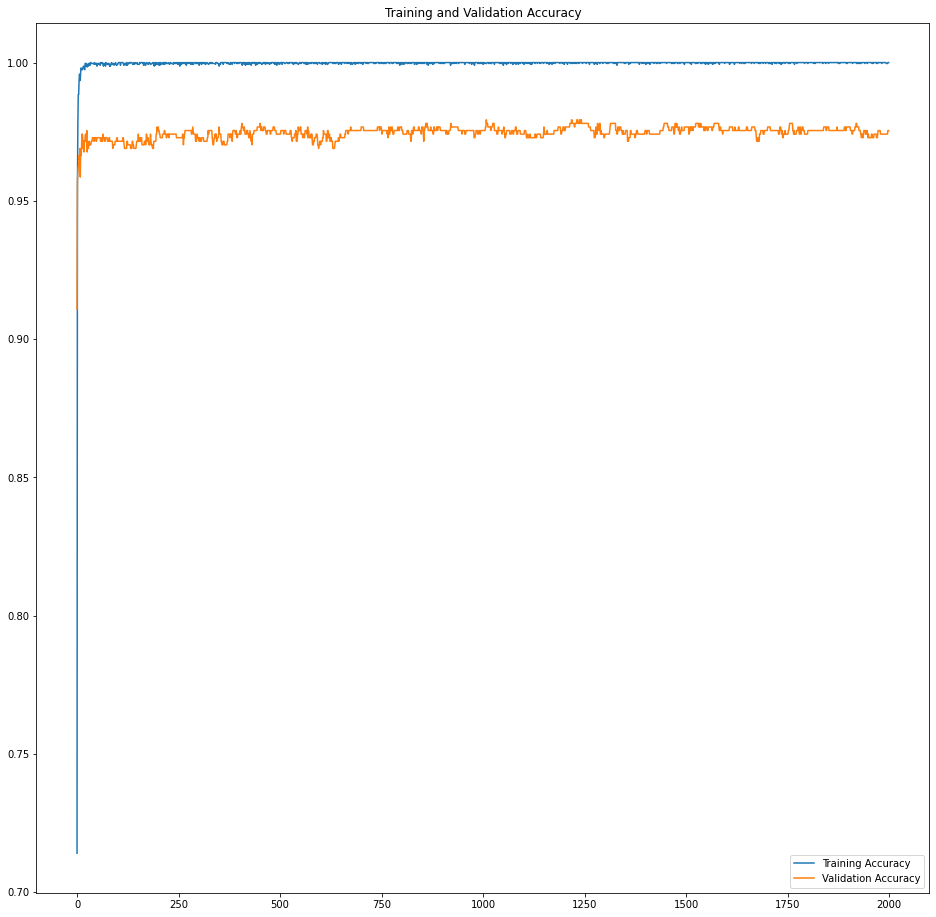

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


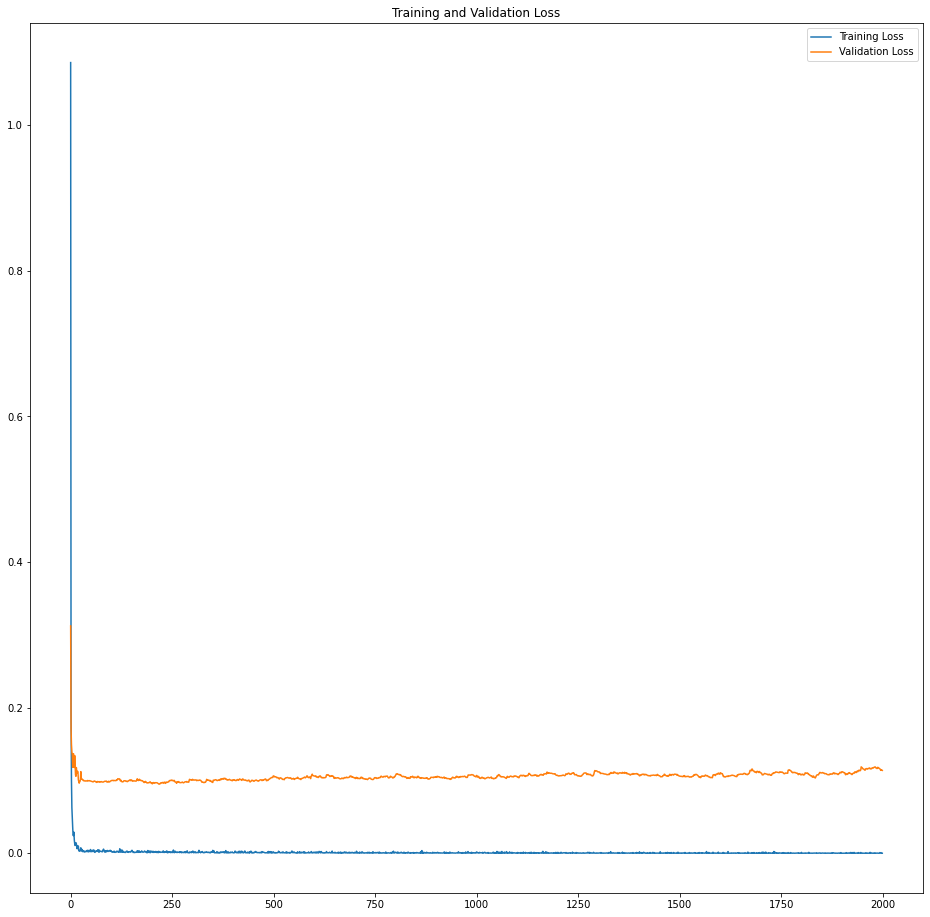

In [27]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 13s 311ms/step - loss: 0.6163 - accuracy: 0.8573
test_indoor_ds_results:test loss, test acc: [0.6163138151168823, 0.8573021292686462]


In [29]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 25s 416ms/step - loss: 1.0073 - accuracy: 0.7978
test_outdoor_ds_results:test loss, test acc: [1.0073295831680298, 0.7977706789970398]


In [30]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 7s 155ms/step - loss: 1.3955 - accuracy: 0.7675
test_belt_ds_results:test loss, test acc: [1.3954761028289795, 0.7674524188041687]


In [31]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/EfficientNetB0_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0200.pb',
 'D:/ModelMedicalWasteCheckpoint/EfficientNetB0_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0400.pb',
 'D:/ModelMedicalWasteCheckpoint/EfficientNetB0_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0600.pb',
 'D:/ModelMedicalWasteCheckpoint/EfficientNetB0_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch0800.pb',
 'D:/ModelMedicalWasteCheckpoint/EfficientNetB0_FreezExtractorOurOutputLayer_LowDeepDense1024-NoClassImbalanced-ALLAugCustomR100-Z025-NormalLR/OurOutputLayer_DeepDense-NoCl

# Testing in testset

In [32]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 3s 83ms/step - loss: 1.1790 - accuracy: 0.7616
Epoch200 
 test_indoor_acc=0.8539576530456543 
 test_outdoor_acc=0.7917197346687317 
 test_belt_acc=0.7615593671798706


35/35 [==============================] - 3s 83ms/step - loss: 1.2062 - accuracy: 0.7665
Epoch400 
 test_indoor_acc=0.8584169745445251 
 test_outdoor_acc=0.7939490675926208 
 test_belt_acc=0.7665457725524902


35/35 [==============================] - 3s 84ms/step - loss: 1.2657 - accuracy: 0.7661
Epoch600 
 test_indoor_acc=0.8584169745445251 
 test_outdoor_acc=0.7968152761459351 
 test_belt_acc=0.7660924792289734


35/35 [==============================] - 3s 84ms/step - loss: 1.2651 - accuracy: 0.7697
Epoch800 
 test_indoor_acc=0.8600891828536987 
 test_outdoor_acc=0.790764331817627 
 test_belt_acc=0.7697189450263977


35/35 [==============================] - 3s 83ms/step - loss: 1.2992 - accuracy: 0.7688
Epoch1000 
 test_indoor_acc=0.8573021292686462 
 test_outdoor_acc=0.7990446090698242 
 test_belt_acc=0.768812358379364


35/35 [==============================] - 3s 84ms/step - loss: 1.3405 - accuracy: 0.7679
Epoch1200 
 test_indoor_acc=0.8589743375778198 
 test_outdoor_acc=0.7888535261154175 
 test_belt_acc=0.7679057121276855


35/35 [==============================] - 3s 85ms/step - loss: 1.3591 - accuracy: 0.7670
Epoch1400 
 test_indoor_acc=0.8623188138008118 
 test_outdoor_acc=0.7964968085289001 
 test_belt_acc=0.7669990658760071


35/35 [==============================] - 3s 84ms/step - loss: 1.3576 - accuracy: 0.7670
Epoch1600 
 test_indoor_acc=0.8550724387168884 
 test_outdoor_acc=0.7955414056777954 
 test_belt_acc=0.7669990658760071


35/35 [==============================] - 3s 85ms/step - loss: 1.3751 - accuracy: 0.7697
Epoch1800 
 test_indoor_acc=0.8545150756835938 
 test_outdoor_acc=0.7920382022857666 
 test_belt_acc=0.7697189450263977


35/35 [==============================] - 3s 84ms/step - loss: 1.3955 - accuracy: 0.7675
Epoch2000 
 test_indoor_acc=0.8573021292686462 
 test_outdoor_acc=0.7977706789970398 
 test_belt_acc=0.7674524188041687


In [33]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)
    

range(200, 2200, 200)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

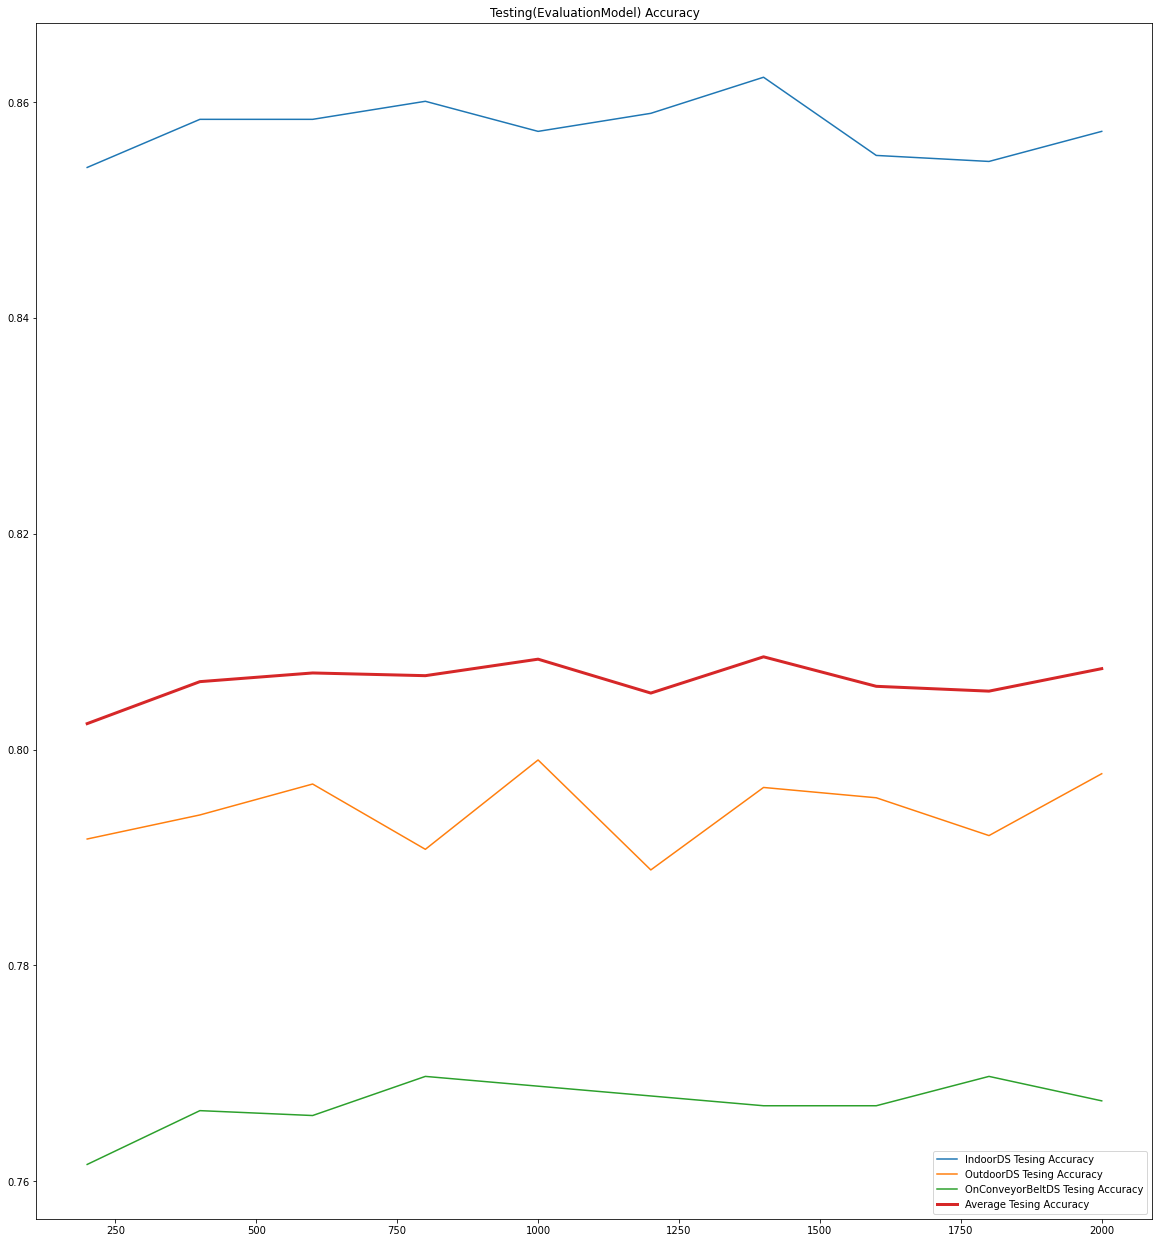

In [34]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

### Max acc

In [35]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.808604896068573
max index -> 6
The [Epoch] of max acc -> 1400


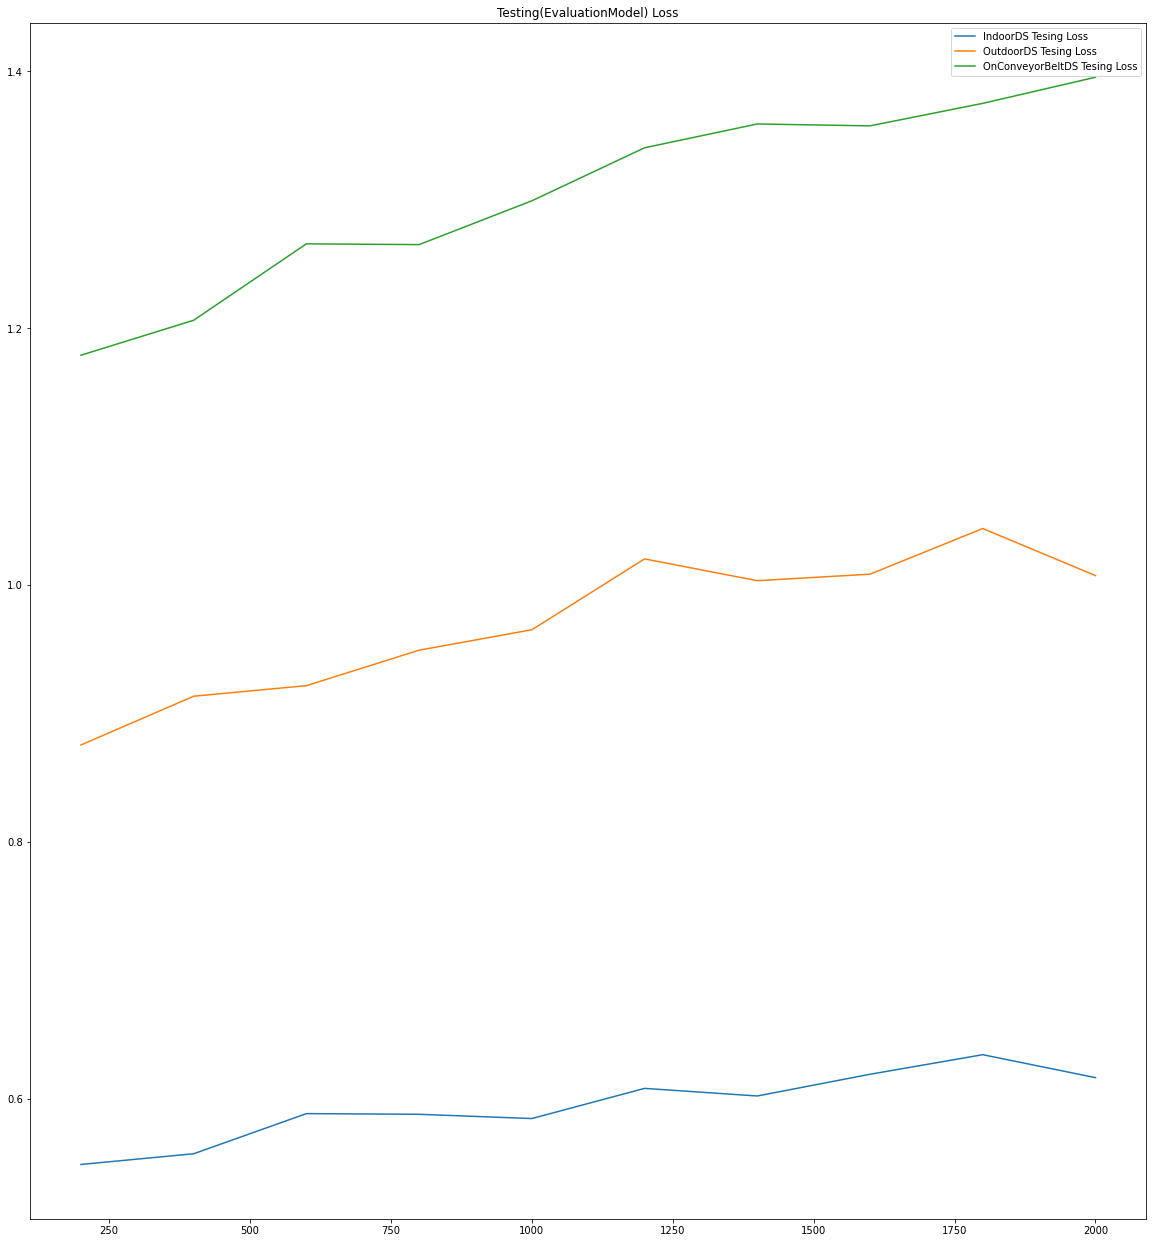

In [36]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [37]:
test_indoor_acc

[0.8539576530456543,
 0.8584169745445251,
 0.8584169745445251,
 0.8600891828536987,
 0.8573021292686462,
 0.8589743375778198,
 0.8623188138008118,
 0.8550724387168884,
 0.8545150756835938,
 0.8573021292686462]

In [38]:
test_outdoor_acc

[0.7917197346687317,
 0.7939490675926208,
 0.7968152761459351,
 0.790764331817627,
 0.7990446090698242,
 0.7888535261154175,
 0.7964968085289001,
 0.7955414056777954,
 0.7920382022857666,
 0.7977706789970398]

In [39]:
test_belt_acc

[0.7615593671798706,
 0.7665457725524902,
 0.7660924792289734,
 0.7697189450263977,
 0.768812358379364,
 0.7679057121276855,
 0.7669990658760071,
 0.7669990658760071,
 0.7697189450263977,
 0.7674524188041687]

In [40]:
test_indoor_loss

[0.5486984252929688,
 0.5570057034492493,
 0.5882850289344788,
 0.5877551436424255,
 0.5844492316246033,
 0.6079313158988953,
 0.6020139455795288,
 0.6189272403717041,
 0.6341705322265625,
 0.6163138151168823]

In [41]:
test_outdoor_loss

[0.8753970861434937,
 0.9133737683296204,
 0.9216026067733765,
 0.9492340683937073,
 0.96512371301651,
 1.020324945449829,
 1.0033602714538574,
 1.0084267854690552,
 1.0439906120300293,
 1.0073295831680298]

In [42]:
test_belt_loss

[1.178967833518982,
 1.2062091827392578,
 1.2657105922698975,
 1.26511812210083,
 1.2992265224456787,
 1.3405290842056274,
 1.3590751886367798,
 1.3576056957244873,
 1.3751330375671387,
 1.3954761028289795]

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
#from numba import cuda
#cuda.select_device(0)
#cuda.close()

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.efficientnet import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer_DeepDense-NoClassImbalanced-NoAug-epoch1400.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=224
img_width=224
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  #ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)
del x_test_indoor,x_test_outdoor,x_test_belt
del x_all

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [3]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=5740
FP=1400
acc=0.803921568627451
all check = 7140


### acc

In [4]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 76.72413793103449%
2WayConnectorforFoley acc = 98.63945578231292%
2WayFoleyCatheter acc = 78.35820895522389%
3WayConnectorforFoley acc = 92.3076923076923%
3Waystopcock acc = 99.09909909909909%
AlcoholBottle acc = 79.375%
AlcoholPad acc = 50.0%
BootCover acc = 39.75903614457831%
CottonBall acc = 75.44910179640718%
CottonSwap acc = 79.72027972027972%
Dilator acc = 78.63247863247864%
DisposableInfusionSet acc = 82.30088495575221%
ExtensionTube acc = 60.16260162601627%
FaceShield acc = 80.24691358024691%
FrontLoadSyringe acc = 65.48672566371681%
GauzePad acc = 55.68181818181818%
Glove acc = 77.08333333333334%
GuideWire acc = 28.57142857142857%
LiquidBottle acc = 64.8854961832061%
Mask acc = 97.66233766233766%
NGTube acc = 47.096774193548384%
NasalCannula acc = 64.60176991150442%
Needle acc = 93.92857142857143%
OxygenMask acc = 89.47368421052632%
PPESuit acc = 81.45161290322581%
PharmaceuticalProduct acc = 82.00934579439252%
Pill acc = 97.05882352941177%
PillBott

In [5]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 89,   1,   0, ...,   0,   0,   0],
       [  1, 145,   0, ...,   0,   0,   0],
       [  0,   0, 105, ...,   0,   1,  10],
       ...,
       [  0,   0,   0, ...,  94,   1,   0],
       [  0,   0,   0, ...,   0, 199,   0],
       [  0,   0,   0, ...,   0,   0,  97]], dtype=int64)

In [6]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[76.72413793,  0.86206897,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.68027211, 98.63945578,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 78.35820896, ...,  0.        ,
         0.74626866,  7.46268657],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 78.33333333,
         0.83333333,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        93.42723005,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 85.0877193 ]])

<AxesSubplot:>

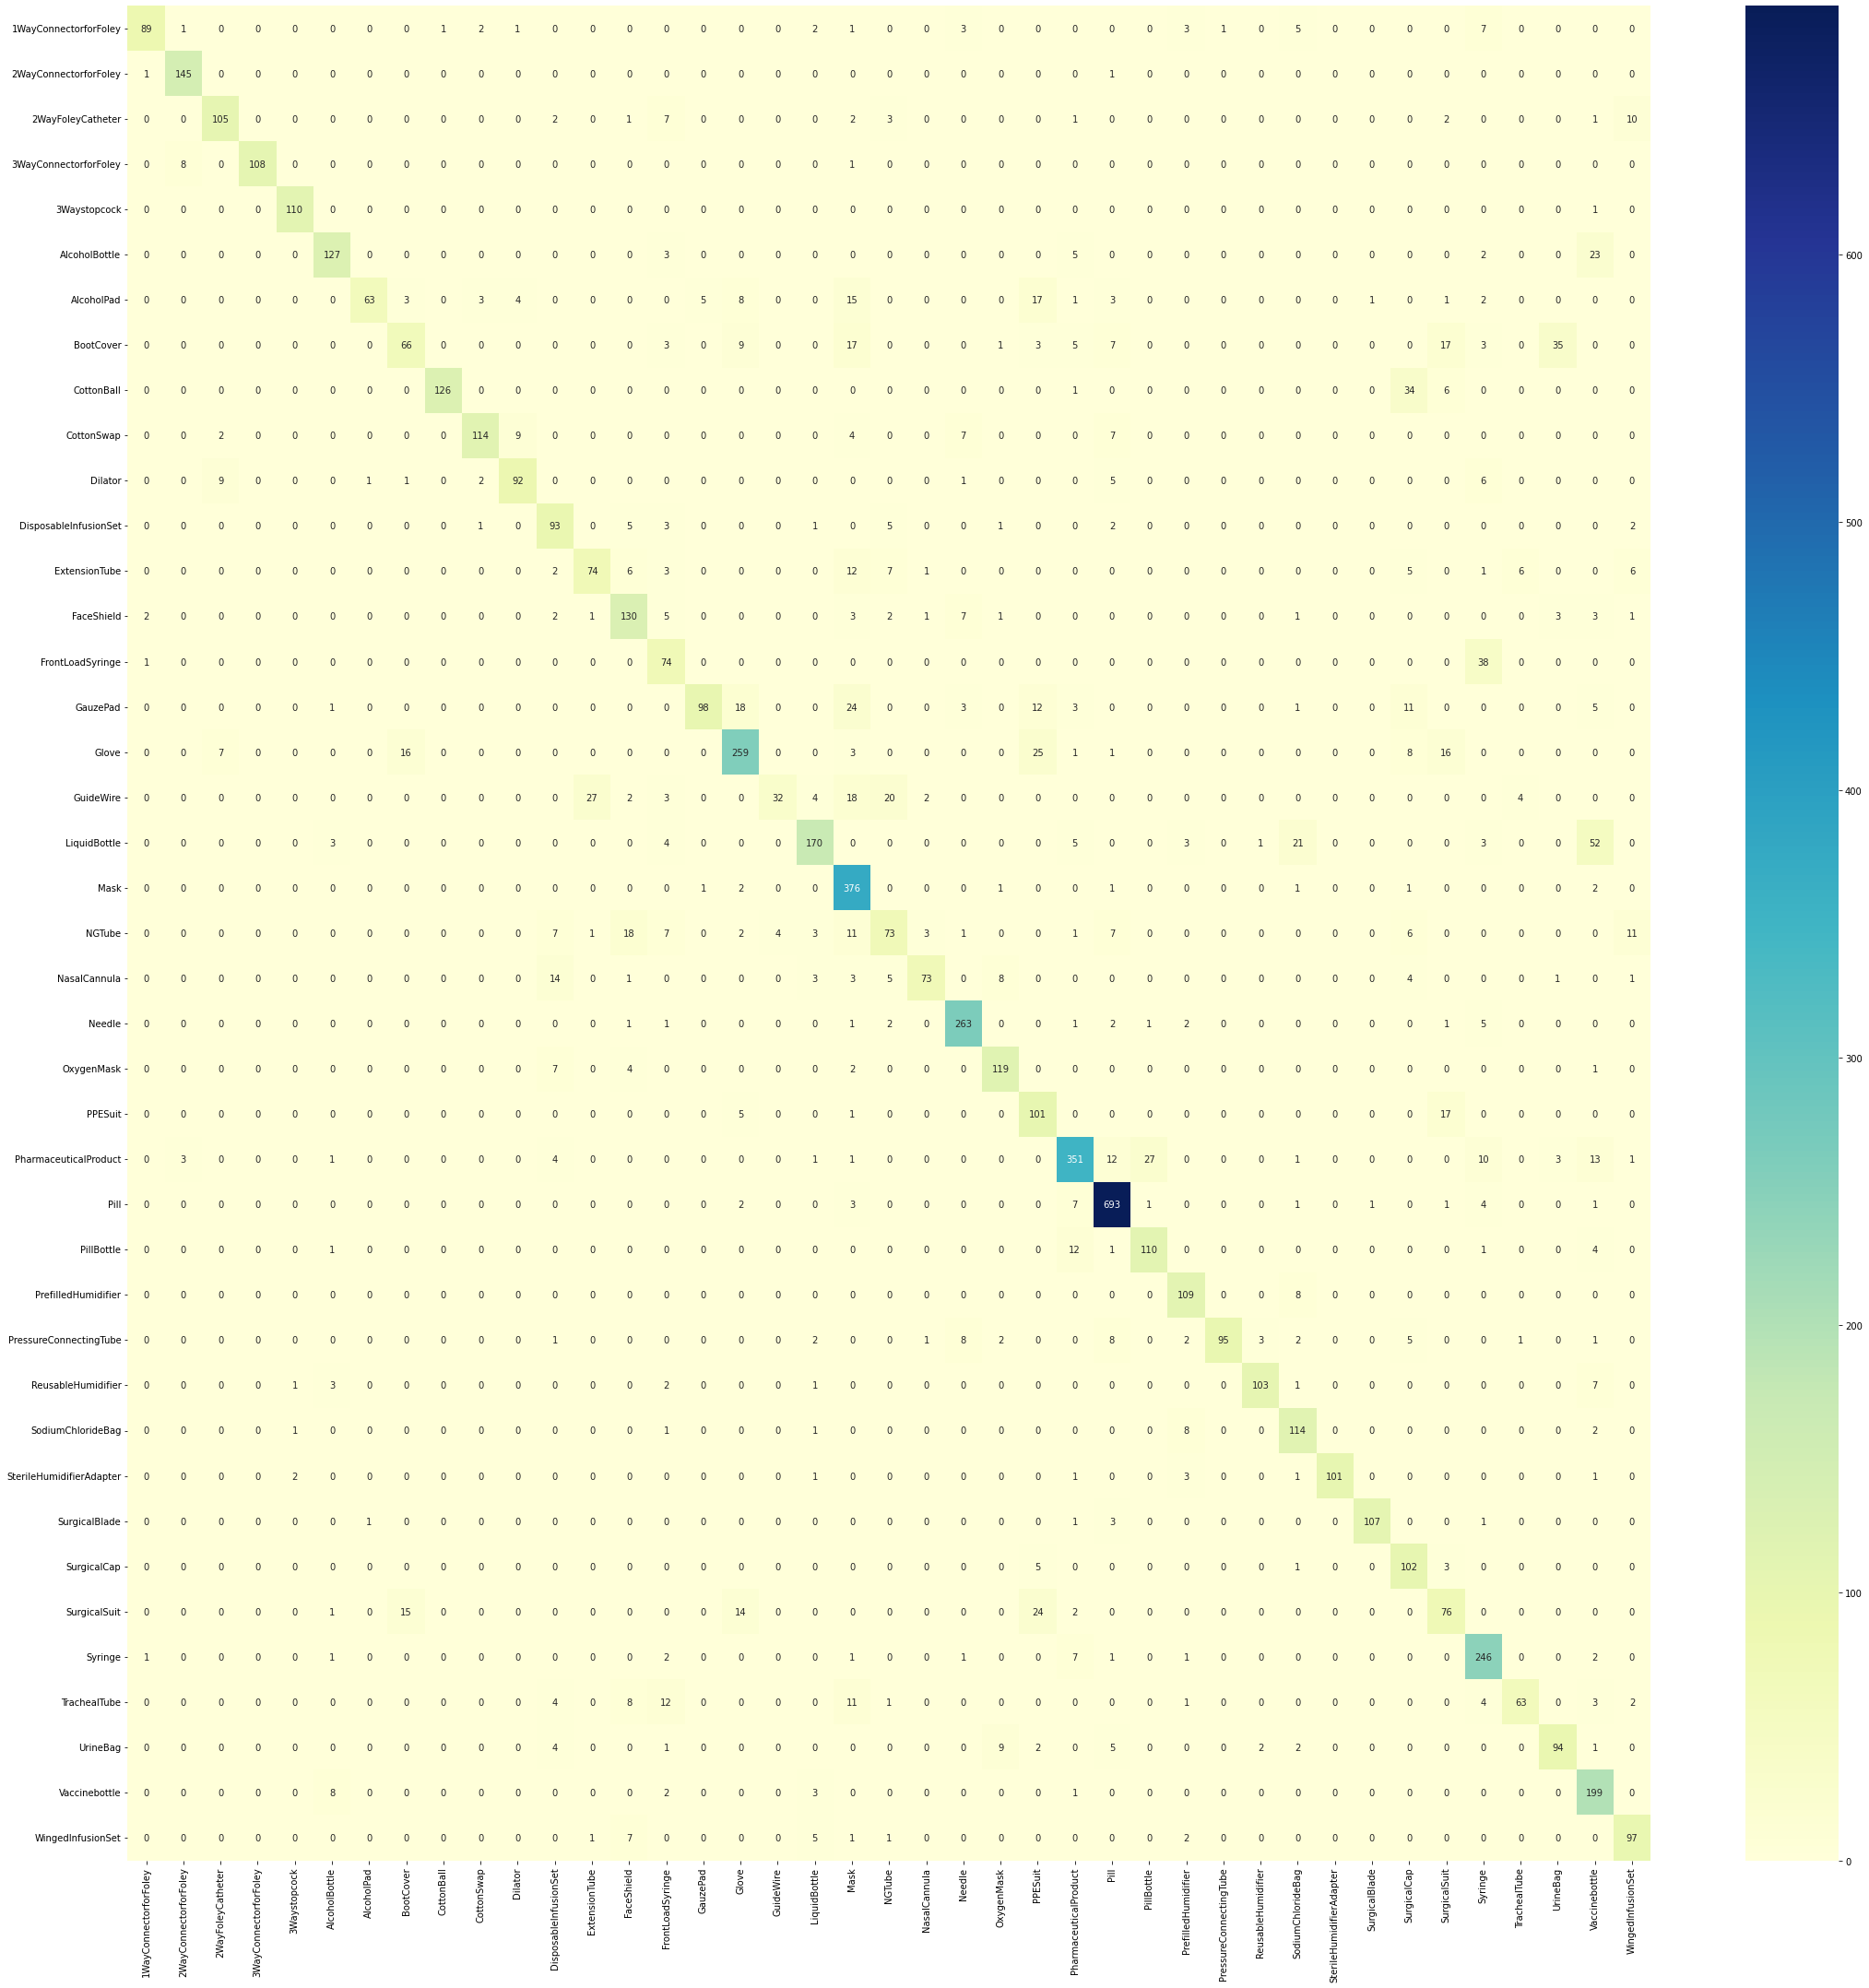

In [7]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt="d")

<AxesSubplot:>

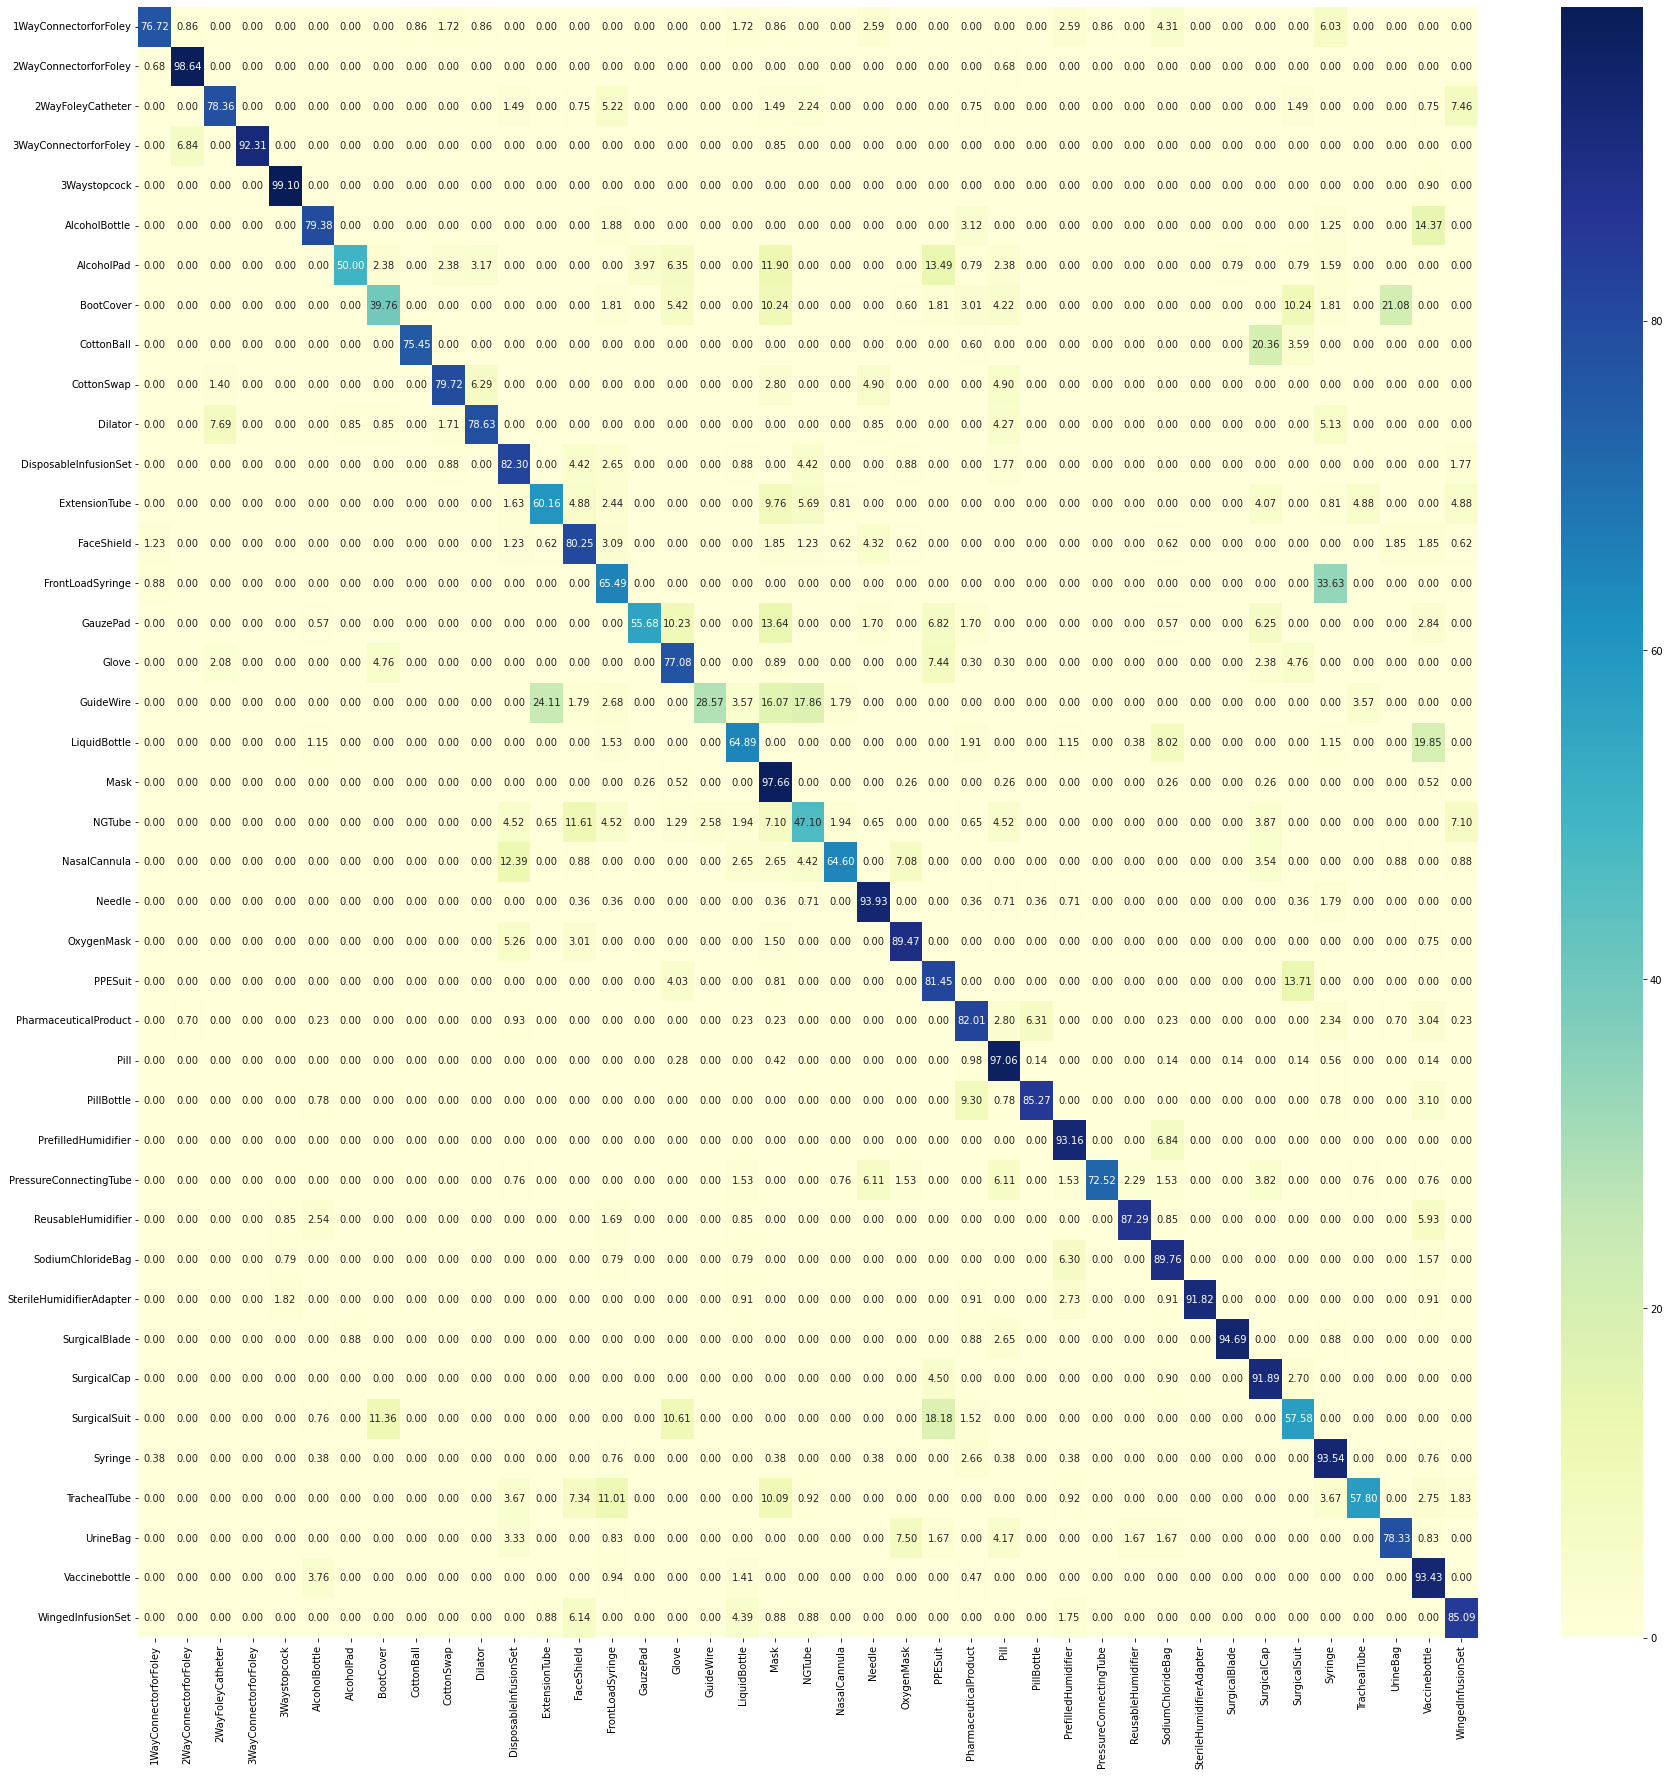

In [8]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt=".2f")